In [3]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from core.utils.func_lib import *
from core.utils.GAN_utils import upconvGAN
from core.utils.GAN_invert_utils import GAN_invert
from core.utils.GAN_utils import upconvGAN
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\big_data_set"

save_dir = r"N:\PonceLab\Users\Alireza\insilico_experiments\gan_inverted\big_data_set_target_center_crop"
os.makedirs(save_dir, exist_ok=True)
refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=256)
for imgid in range(len(refimgnms)):
    img = ToPILImage()(refimgtsr[imgid])
    file_name = refimgnms[imgid].split('.')[0]
    image_format = "png"
    img.save(join(save_dir, f"{file_name}.{image_format}"))

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

  0%|          | 0/50000 [00:00<?, ?it/s]

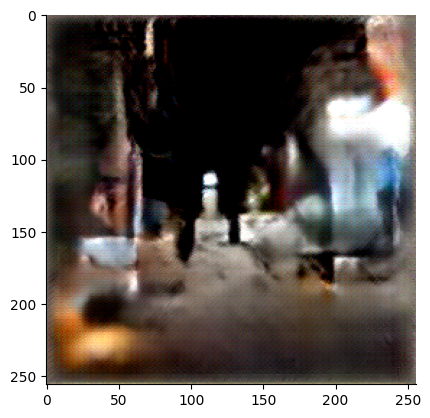

In [30]:

save_dir = r"N:\PonceLab\Users\Alireza\insilico_experiments\gan_inverted\big_data_set_real_size"
os.makedirs(save_dir, exist_ok=True)
G = upconvGAN("fc6").cuda().eval()
for imgid in range(len(refimgnms)):
        targnm, target_imgtsr_real = refimgnms[imgid], refimgtsr[imgid:imgid + 1]

        target_img = target_imgtsr_real[0]
        
        z_opts, img_opts= GAN_invert(G, target_img.cuda(), max_iter=int(5E4),
                                print_progress=False, batch_size = 1)
        #imgs = resize_and_pad_tsr(img_opts, (147, 147), (40, 40))
        imgs = img_opts
        plt.imshow(ToPILImage()(imgs[0]))
        file_name = refimgnms[imgid].partition(".")[0]
        image_format = "png"
        img = ToPILImage()(imgs[0])
        img.save(join(save_dir, f"{file_name}.{image_format}"))

In [ ]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
import torch.nn.functional as F

#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\tiny_set_image"

net_name = "resnet50" # corenet_s, resnet50, resnet50_linf_8, alexnet, vgg16, vgg16_bn, vgg19, vgg19_bn
layer_name = ['.layer3.5.BatchNorm2dbn3']#'.BatchNorm2dbn3', '.features.Conv2d8', '.features.Conv2d6', '.features.Conv2d3']#[".features.Conv2d10", ".features.Conv2d6"]
layer_short = "--"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (147, 147)
pading_size = (40, 40) 
popsize = 1000
score_method = "cosine"

G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)
imgid = 1
target_imgtsr_real =  refimgtsr[imgid:imgid + 1]

img_opts_rsz = F.interpolate(img_opts.cpu(), size=(227, 227))
imgid = 2
target_imgtsr = img_opts_rsz[imgid:imgid + 1]
init_code = np.array(z_opts.detach().cpu()[imgid:imgid + 1])

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 0
#unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
#               scorer_random, layer_name, popsize=popsize, seed=pop_resampling_id)
unit_mask_dict_random, unit_tsridx_dict_random = set_most_active_population_recording(
                scorer_random, layer_name, target_imgtsr, pading_size, img_size, popsize=popsize)
#print("unit mask dict", unit_tsridx_dict_random)

fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random, layer_name, input_size,show_fig=False)

targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)

targ_actmat_real, target_imgtsr_real_resize = encode_image(scorer_random, target_imgtsr_real, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)

print("act mat shape: ", targ_actmat.shape)

targlabel = os.path.splitext(targnm)[0]
print("act mat shape: ", targ_actmat.shape)
target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
        target_imgtsr_resized

# showt the tensor image 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"

#set objective function
objfunc = set_objective('inflate_unit', targ_actmat, unit_id=60, popul_mask=None, normalize=False)
## set optimizer
optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                init_code=init_code, Aupdate_freq=10,
                maximize=True, random_seed=None, optim_params={})

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores, best_codes =\
    run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None,
            meta_data_df=None, trial_param_dict=None, init_code=init_code,
            titlestr =title_str, steps=10, RFresize=True, corner=pading_size, imgsize=img_size,
            RF_mask=fitdict_random["fitmap"], save_plot=None)


fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(last_gem_img_maske.mean(dim=0)))
ax.axis("off")
ax.set_title(targlabel+" mean")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(best_imgs[np.argmax(best_scores)]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()
print("final MSE score: ", np.square(actmat_all[scores_all.argmax(),:] - targ_actmat).mean())
figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                title_str=title_str)

#plot the actmat
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.plot(targ_actmat_real[0], label="real", color="red")
ax.plot(targ_actmat[0], label="invert", color="blue")
ax.legend()

scorer_random.cleanup()

In [ ]:
popact_norm = np.linalg.norm(targ_actmat, axis=1,keepdims=True)
targact_norm = np.linalg.norm(targ_actmat_real, axis=1,keepdims=True)
scores = ((targ_actmat @ targ_actmat_real.T) / popact_norm / targact_norm).squeeze(axis=1)
print("final coisne score: ", scores.mean())

In [ ]:
scores = - np.square(targ_actmat_real - targ_actmat).mean(axis=1)
print("final MSE score: ", scores.mean())

In [ ]:
actmat_all[-1,:].shape

In [ ]:
import os
import sys
sys.path.append(r"C:\Users\Alireza\Documents\Git\Cosine-Project")
from inSilico_experiments.utils.func_lib import *
import matplotlib.pylab as plt
##
import warnings
warnings.filterwarnings("ignore") # becairfull with this

from core.utils.GAN_utils import upconvGAN
from core.utils.Optimizers import CholeskyCMAES
from core.utils.CNN_scorers import TorchScorer, resize_and_pad_tsr
#%% 
# Set parameters
refimgdir = r"C:\Data\cosine\insilico_experiments\data\tiny_set_image"

net_name = "resnet50" # corenet_s, resnet50, resnet50_linf_8, alexnet, vgg16, vgg16_bn, vgg19, vgg19_bn
layer_name = ['.layer3.5.BatchNorm2dbn3']#, '.features.Conv2d8', '.features.Conv2d6', '.features.Conv2d3']#[".features.Conv2d10", ".features.Conv2d6"]
layer_short = "--"
gan_name = "fc6"
input_size = (3, 227, 227)
img_size = (147, 147)
pading_size = (40, 40) 
popsize = 1000
score_method = "cosine"

refimgnms, refimgtsr = load_ref_imgs(
        imgdir=refimgdir, preprocess_type='center_crop', image_size=227)

imgid = 2

targnm, target_imgtsr = refimgnms[imgid], refimgtsr[imgid:imgid + 1]
G = upconvGAN(gan_name).cuda()
G.requires_grad_(False)
code_length = G.codelen

scorer_random = TorchScorer(net_name)
module_names, module_types, module_spec = get_module_names(
        scorer_random.model, input_size, "cuda", False)
pop_resampling_id = 0
#unit_mask_dict_random, unit_tsridx_dict_random = set_random_population_recording(
#                scorer_random, layer_name, popsize=popsize, seed=pop_resampling_id)
unit_mask_dict_random, unit_tsridx_dict_random = set_most_active_population_recording(
                scorer_random, layer_name, target_imgtsr, pading_size, img_size, popsize=popsize)
#print("unit mask dict", unit_tsridx_dict_random)

fitdict_random = fr_estimatir(scorer_random, G, unit_tsridx_dict_random, layer_name, input_size,show_fig=False)

targ_actmat, target_imgtsr_resized = encode_image(scorer_random, target_imgtsr, key=layer_name,
                        RFresize=True, corner=pading_size, imgsize=img_size)

print("act mat shape: ", targ_actmat.shape)

targlabel = os.path.splitext(targnm)[0]
print("act mat shape: ", targ_actmat.shape)
target_imgtsr_resized_RF_masked =\
        (torch.from_numpy(np.absolute(fitdict_random["fitmap"][None,:,:])) / fitdict_random["fitmap"].max()) *\
        target_imgtsr_resized

# showt the tensor image 
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(target_imgtsr_resized_RF_masked[0]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()


title_str = f"{targnm}-{popsize}-{score_method}-{layer_short}-{gan_name}"
#set objective function
objfunc = set_objective(score_method, targ_actmat, popul_mask=None, normalize=False)
## set optimizer
optimizer = CholeskyCMAES(code_length, population_size=None, init_sigma=3,
                init_code=np.zeros([1, code_length]), Aupdate_freq=10,
                maximize=True, random_seed=None, optim_params={})

codes_all, scores_all, actmat_all, generations, last_gem_img, last_gem_img_maske, best_imgs, best_imgs_RF_masked, best_scores, best_codes =\
        run_evol(scorer_random, objfunc, optimizer, G, reckey=layer_name, savedir=None, meta_data_df=None, trial_param_dict=None,
        titlestr =title_str, steps=100, RFresize=True, corner=pading_size, imgsize=img_size, RF_mask=fitdict_random["fitmap"], save_plot=None)
# 

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(last_gem_img_maske.mean(dim=0)))
ax.axis("off")
ax.set_title(targlabel+" mean")
plt.show()

fig, ax = plt.subplots(1, 1, figsize=(5, 5))
ax.imshow(ToPILImage()(best_imgs[np.argmax(best_scores)]))
ax.axis("off")
ax.set_title(targlabel)
plt.show()

figh = visualize_popul_act_evol(actmat_all, generations, targ_actmat, titlestr=title_str)
print("final MSE score: ", np.square(actmat_all[scores_all.argmax(),:] - targ_actmat).mean())
trajectory_fig = visualize_trajectory(scores_all, generations, codes_arr=codes_all,
                                                title_str=title_str)
scorer_random.cleanup()
